In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4, Model_v5, Model_v6, Model_v7, Model_v8, Model_v9, Model_v10, Model_v11
from Resources.Model import Model_v12, Model_v13, Model_v16, Model_v17, Model_v18, Model_v19
from Resources.Game import *
import Resources


In [2]:
for func in dir(Resources.Model):

    # 13 is too large, takes too long (4x as long as second most time taken)
    if 'Model_v' in func and int(func[7:]) in [15, 18, 19, 20, 21]:

        model = getattr(Resources.Model, func)()
        print(func)

        pars = [i for i in model.parameters()]
        print('number of parameters: ', sum(i.numel() for i in model.parameters()))

        # pars = [i for i in model.parameters()]
        # for i in pars:
        #     print(i.shape)
        #     print(i.numel())

Model_v15
number of parameters:  2907033
Model_v18
number of parameters:  5421937
Model_v19
number of parameters:  3340801
Model_v20
number of parameters:  1663521
Model_v21
number of parameters:  5052449


In [3]:
model1 = Model_v11()

pars = [i for i in model.parameters()]
for i in pars:
    print(i.shape)
    print(i.numel())
# print('number of parameters: ', sum(i.numel() for i in model.parameters()))


In [4]:
# Get number of training batches
training_data = os.listdir('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8_3')
i_training_data = 0
while 'inputs_'+str(i_training_data + 1) in training_data:
    i_training_data += 1
n_training_data = i_training_data

### Model Architecture Comparison

In [5]:
models_used = [15]
name = 'v8_3'

error_hist_tot_models = []
criterion = nn.MSELoss()

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 5            # replay helps, but takes too long here
weight_decay = 1e-7

for func in dir(Resources.Model):

    # 13 is too large, takes too long (4x as long as second most time taken)
    if 'Model_v' in func and int(func[7:]) in models_used:

        model_ind = int(func[7:])
        model = getattr(Resources.Model, func)()
        print(func)

        pars = [i for i in model.parameters()]
        print('number of parameters: ', sum(i.numel() for i in model.parameters()))
    
    else:
        continue

    t0 = time.time()

    error_hist_curr_models = []

    for batch in range(1, 2000):#n_training_data + 1):

        if batch % 10 == 0:
            print(batch)

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        
        # get error of new data (without backprop)
        model.eval()
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 250 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            # error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print('time in total: ', time.time() - t0)

    error_hist_tot_models.append(error_hist_curr_models)

    torch.save(error_hist_curr_models, './error temp {}'.format(model_ind))

Model_v15
number of parameters:  2907033
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
model:  15 training batch  250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
model:  15 training batch  500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
model:  15 training batch  750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
model:  15 training batch  1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
model:  15 training batch  1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
model:  15 training batch  1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
mod

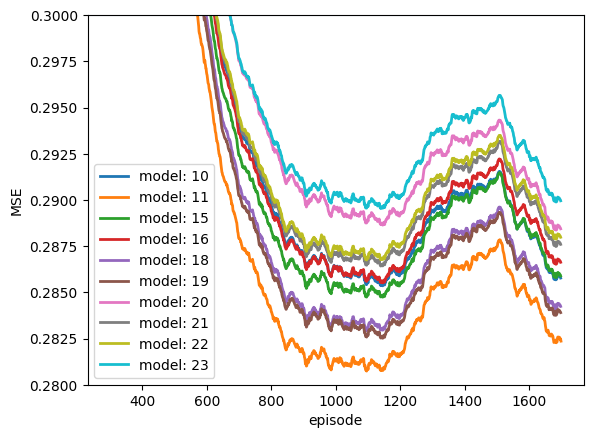

In [17]:
models_used = [10, 11, 15, 16, 18, 19, 20, 21, 22, 23]
av_window = 300
for m in range(len(models_used)):
    error_hist_curr = torch.load('./temp errors/error temp {}'.format(models_used[m]))
    plt.plot(range(av_window, len(error_hist_curr) - av_window), [np.mean(error_hist_curr[i:i+av_window*2]) for i in range(len(error_hist_curr) - av_window*2)], label='model: '+str(models_used[m]), lw=2)

plt.legend()
plt.ylim([0.28, 0.3])
# plt.xlim([700, 800])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()
    

In [12]:
for func in dir(Resources.Model):

    # 13 is too large, takes too long (4x as long as second most time taken)
    if 'Model_v' in func and int(func[7:]) in [10, 11, 15, 16, 17, 18, 19, 20, 21, 22, 23]:

        model = getattr(Resources.Model, func)()
        print(func)

        pars = [i for i in model.parameters()]
        print('number of parameters: ', sum(i.numel() for i in model.parameters()))

Model_v10
number of parameters:  2598997
Model_v11
number of parameters:  22465277
Model_v15
number of parameters:  2907033
Model_v16
number of parameters:  9020825
Model_v17
number of parameters:  1483005
Model_v18
number of parameters:  5421937
Model_v19
number of parameters:  3340801
Model_v20
number of parameters:  1663521
Model_v21
number of parameters:  5052449


In [ ]:
# 11 best but huge
# 19 2nd best and small (3.3m)
# 15 very good and small (2.9m)
# 17 not good and tiny (1.4m, many convolutions, small fc)
# 20 not good and tiny (1.6m)

In [6]:
av_window = 200
models_used = [6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models):
    # if models_sed[e] in [6, 7]:
    #     continueu
    plt.plot(range(av_window, len(error_hist) - av_window), [np.mean(error_hist[i:i+av_window*2]) for i in range(len(error_hist) - av_window*2)], label='model: '+str(models_used[e]), lw=3)

plt.legend()
plt.ylim([0.275, 0.295])
plt.xlim([700, 800])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

NameError: name 'error_hist_tot_models' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
# Model 11 is best (also biggest) -> larger can generally learn more

# lessons from bad models:
# 14 is pooling -> definitely no pooling
# 12 is 11 but shallow -> dont go too shallow
# 6 is fully connected only -> already concluded that that's not optimal
# 7 just too small -> larger can generally learn more

# lessons from good models
# 8 decent but suboptimal
# 9 decent but not efficient (huge but only slightly better)
# 10 is like 8 but deeper -> depth maybe only brings large benefits for wide base ?
# 15 is like 12 but with direct input pooling -> much better
# -> direct input pooling seems to help

# move on with

In [3]:
models_used2 = [16, 17, 18, 19]
name = 'v8_3'

# error_hist_tot_models2 = []
criterion = nn.MSELoss()

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here
weight_decay = 1e-7

# for func in dir(Resources.Model):

#     # 13 is too large, takes too long (4x as long as second most time taken)
#     if 'Model_v' in func and int(func[7:]) in models_used:

#         model_ind = int(func[7:])
#         model = getattr(Resources.Model, func)()
#         print(func)

#         pars = [i for i in model.parameters()]
#         print('number of parameters: ', sum(i.numel() for i in model.parameters()))
    
#     else:
#         continue

for model_ind in models_used2:

    print(' -- model: ', model_ind)

    if model_ind == 16:
        model = Model_v16()
    if model_ind == 17:
        model = Model_v17()
    if model_ind == 18:
        model = Model_v18()
    if model_ind == 19:
        model = Model_v19()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    t0 = time.time()

    error_hist_curr_models = []

    for batch in range(1, 1000):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 250 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print('time in total: ', time.time() - t0)

    error_hist_tot_models.append(error_hist_curr_models)

 -- model:  16
number of parameters:  5163261
model:  16 training batch  250
model:  16 training batch  500
model:  16 training batch  750
time in total:  1104.2451419830322
 -- model:  17
number of parameters:  1483005
model:  17 training batch  250
model:  17 training batch  500
model:  17 training batch  750
time in total:  951.3708720207214
 -- model:  18
number of parameters:  5421937
model:  18 training batch  250
model:  18 training batch  500
model:  18 training batch  750
time in total:  1057.0803978443146
 -- model:  19
number of parameters:  3340801
model:  19 training batch  250
model:  19 training batch  500
model:  19 training batch  750
time in total:  691.3378372192383


In [ ]:
# model 17 with 1.4m parameters takes 950s
# model 19 with 3.3m parameters takes 690s
# -> convolutions take much longer than fc layers

In [4]:
av_window = 200
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models):
    plt.plot(range(av_window, len(error_hist) - av_window), [np.mean(error_hist[i:i+av_window*2]) for i in range(len(error_hist) - av_window*2)], label='model: '+str(models_used[e]), lw=3)

plt.legend()
plt.ylim([0.275, 0.295])
plt.xlim([700, 800])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

NameError: name 'models_used' is not defined

<Figure size 800x500 with 0 Axes>

### Visualise Individual Training Labels / Model Outputs

In [38]:
name = 'v8_3' # name of used run

model = Model_v8()
model_saves = os.listdir('../Monte Carlo/Model Saves MC {}'.format(name))
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC {}/model_{}_batches'.format(name, newest_model)))
criterion = nn.MSELoss()

inputs = []
labels = []
for index in range(latest_batch_index, latest_batch_index + 1):
    inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
    labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

inputs_tens = torch.cat(inputs).float() # bool -> float
labels_tens = torch.cat(labels)

# # samples from exp distribution, more recent -> more likely
# decay_rate = 0.02
# prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
# prob = prob/sum(prob)
# num_samples = n_replay
# samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
# for index in samples:
#     inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
#     labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

# inputs_tens = torch.cat(inputs).float() # bool -> float
# labels_tens = torch.cat(labels)   

out = model(inputs_tens)
out = out.view(out.shape[0])

zero_out = torch.zeros_like(labels_tens)

loss = criterion(out, labels_tens)
loss_trivial = criterion(zero_out, labels_tens)

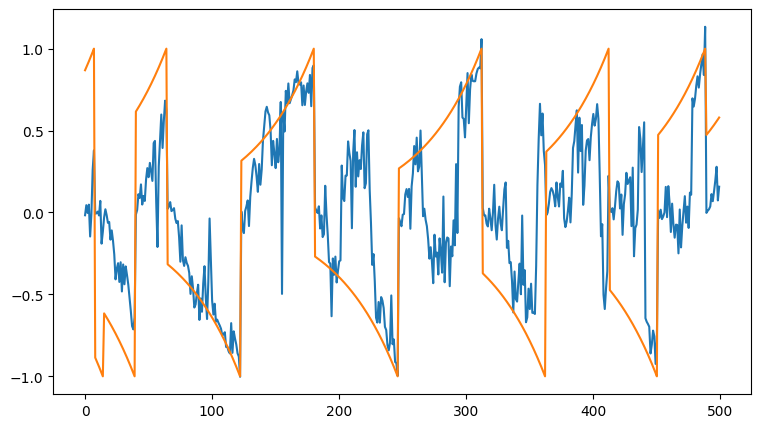

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(out.detach().numpy()[0:500])
plt.plot(labels_tens.detach().numpy()[0:500])
plt.show()

Model_v28
number of parameters:  2410881
10
20
30
40
50
60
70
80
90
100


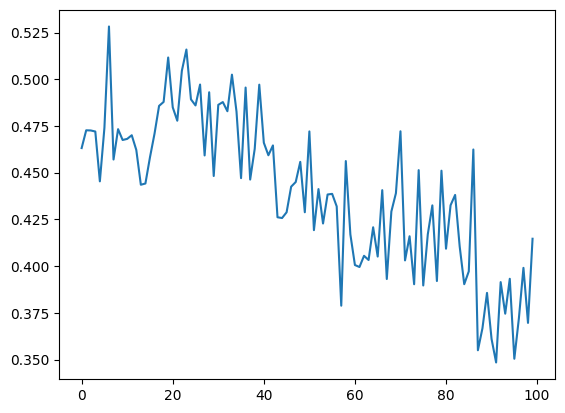

110
120
130
140
150
160
170
180
190
200


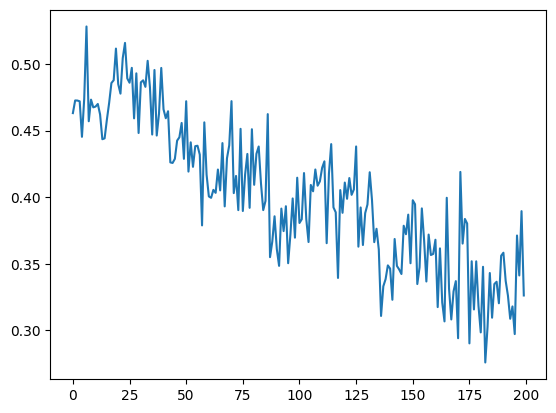

210
220
230
240
250
model:  28 training batch  250
260
270
280
290
300


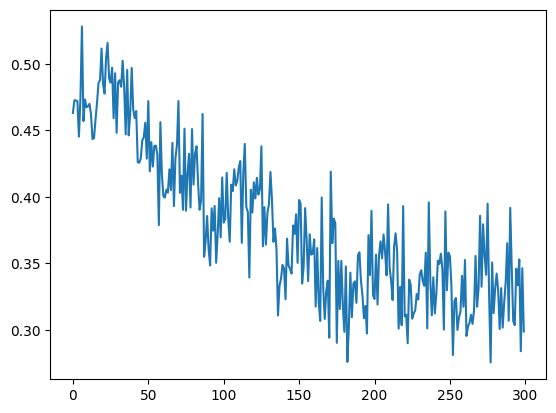

310
320
330
340
350
360
370
380
390
400


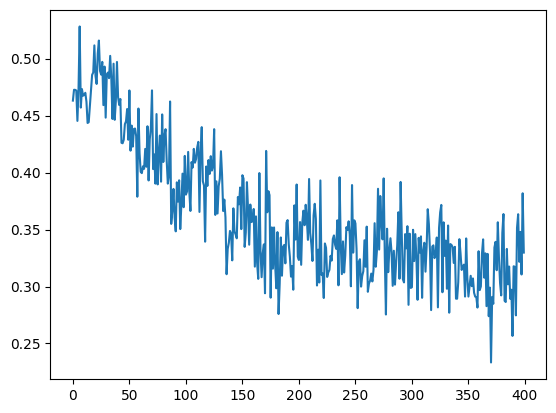

410
420
430
440
450
460
470
480
490
500
model:  28 training batch  500


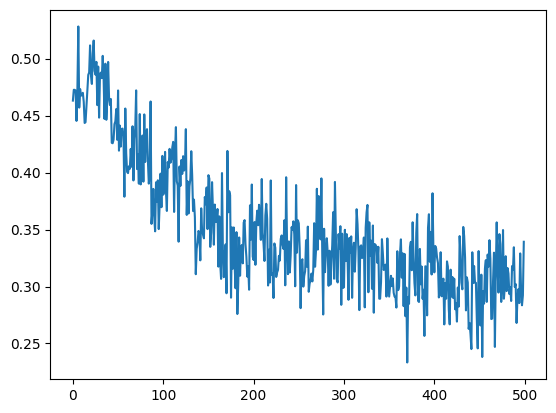

510
520
530
540
550
560
570
580
590
600


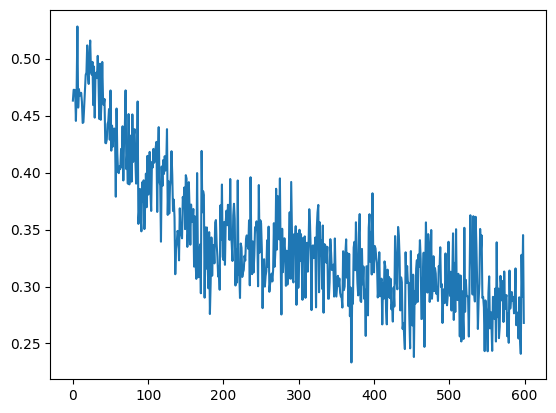

610
620
630
640
650
660
670
680
690
700


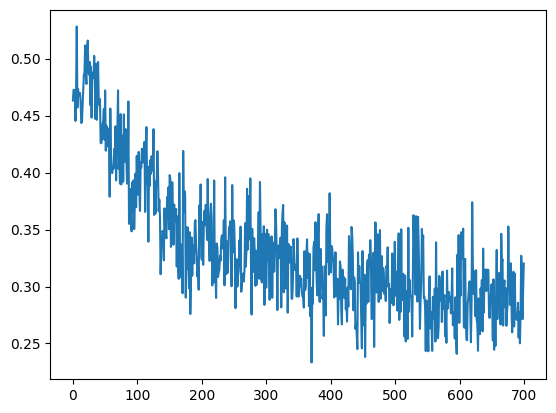

710
720
730
740
750
model:  28 training batch  750
760
770
780
790
800


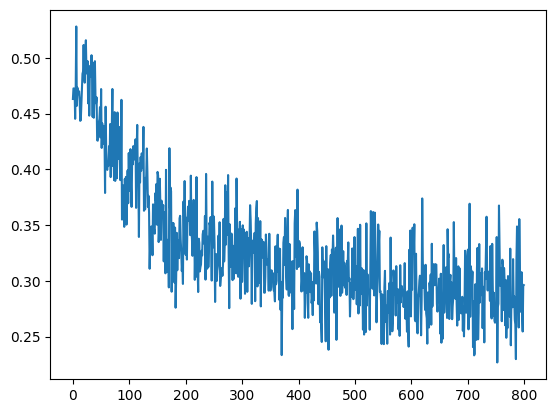

810
820
830
840
850
860
870
880
890
900


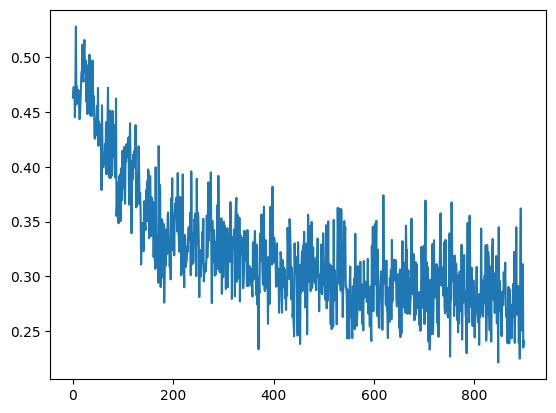

910
920
930
940
950
960
970
980
990
1000
model:  28 training batch  1000


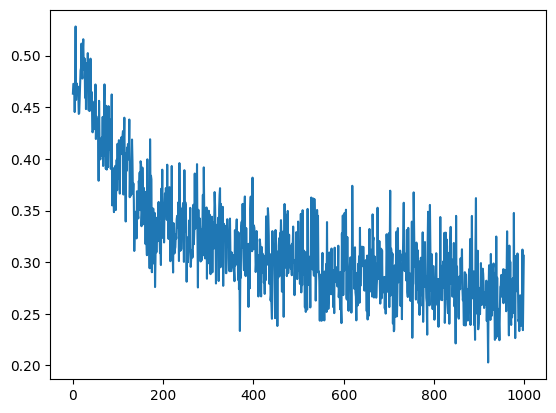

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


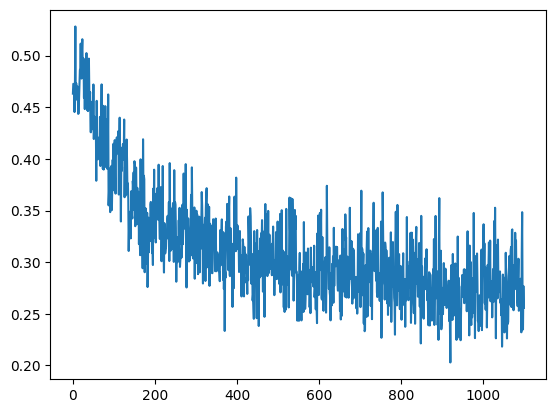

1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


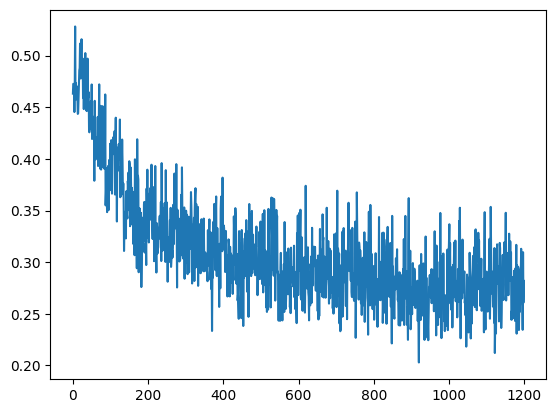

1210
1220
1230
1240
1250
model:  28 training batch  1250
1260
1270
1280
1290
1300


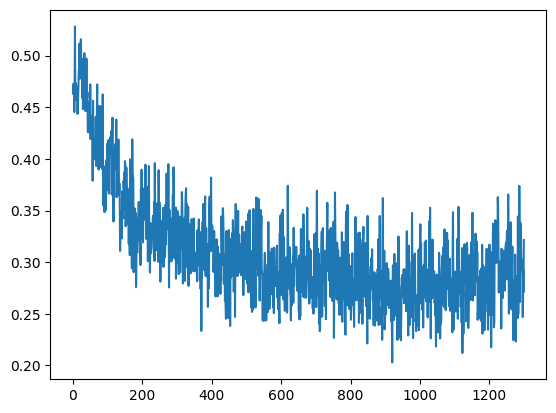

1310
1320
1330
1340
1350
1360
1370
1380
1390
1400


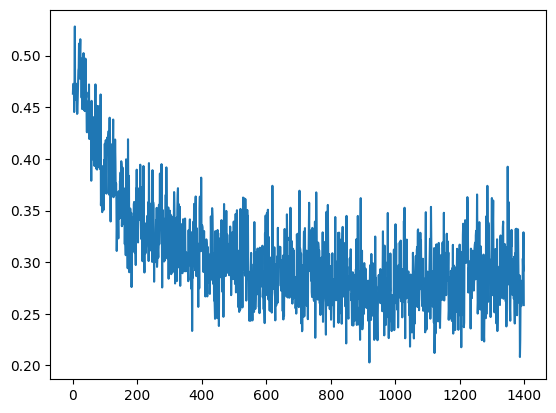

1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
model:  28 training batch  1500


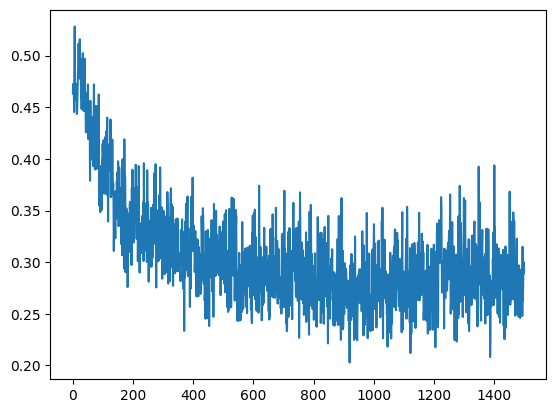

1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


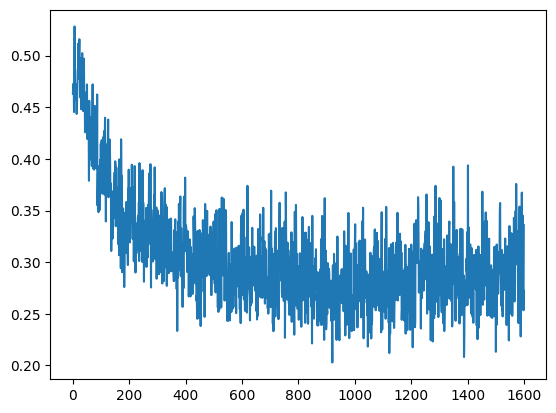

1610
1620
1630
1640
1650
1660
1670
1680
1690
1700


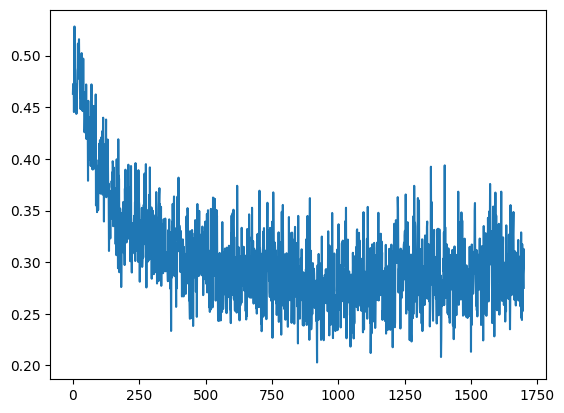

1710
1720
1730
1740
1750
model:  28 training batch  1750
1760
1770
1780
1790
1800


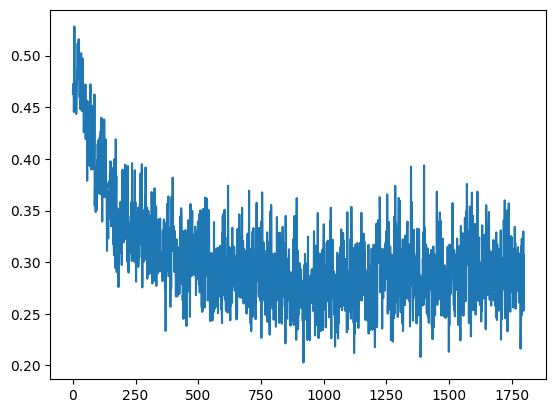

1810
1820
1830
1840
1850
1860
1870
1880
1890
1900


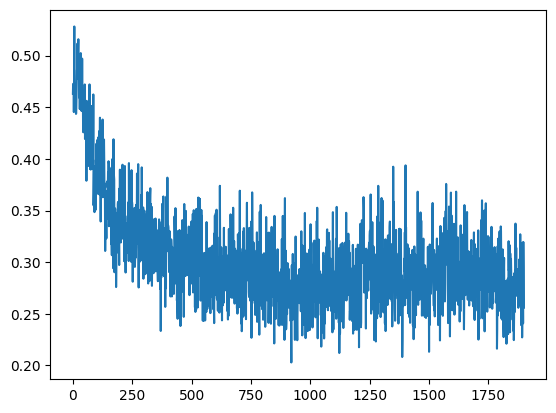

1910
1920
1930
1940
1950
1960
1970
1980
1990
time in total:  3201.0653080940247


In [6]:
models_used = [28]
name = 'v8_3'

error_hist_tot_models_v28 = []
criterion = nn.MSELoss()

lr0 = 3e-4
a = 250
n_batches = 1
n_replay = 5            # replay helps, but takes too long here
weight_decay = 1e-7

for func in dir(Resources.Model):

    # 13 is too large, takes too long (4x as long as second most time taken)
    if 'Model_v' in func and int(func[7:]) in models_used:

        model_ind = int(func[7:])
        model = getattr(Resources.Model, func)()
        print(func)

        pars = [i for i in model.parameters()]
        print('number of parameters: ', sum(i.numel() for i in model.parameters()))
    
    else:
        continue

    t0 = time.time()

    error_hist_curr_models = []

    for batch in range(1, 2000):#n_training_data + 1):

        if batch % 10 == 0:
            print(batch)

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        
        # get error of new data (without backprop)
        model.eval()
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 250 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            # error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if batch % 100 == 0:
            plt.plot(error_hist_curr_models)
            plt.show()

    print('time in total: ', time.time() - t0)

    error_hist_tot_models_v28.append(error_hist_curr_models)

    torch.save(error_hist_curr_models, './error temp {}'.format(model_ind))

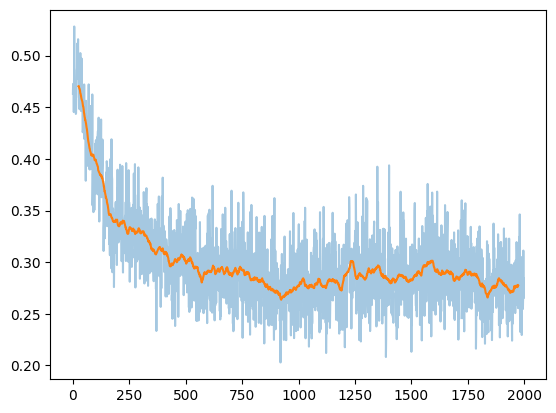

In [14]:
av_window = 50
plt.plot(error_hist_tot_models_v28[0], alpha=0.4)
plt.plot(range(av_window//2, len(error_hist_tot_models_v28[0]) - av_window//2), [np.nanmean(error_hist_tot_models_v28[0][i:(i+av_window)]) for i in range(len(error_hist_tot_models_v28[0]) - av_window)], label='mean')
plt.show()

In [7]:
print(len(error_hist_tot_models_v28[0]))

99


# Validate Model on different data set

250
500
750
1000
1250
1500
1750
time in total:  269.4205708503723


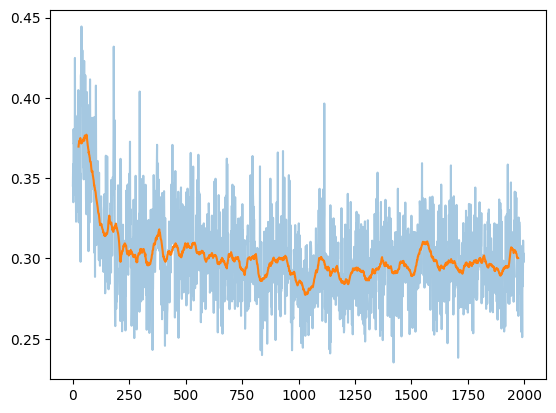

In [10]:
name_val = 'v25'

t0 = time.time()

error_hist_val = []

for batch in range(1, 2000):#n_training_data + 1):

    if batch % 250 == 0:
        print(batch)

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name_val, index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name_val, index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)
    
    # get error of new data (without backprop)
    model.eval()
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist_val.append(loss.item())

print('time in total: ', time.time() - t0)

av_window = 50
plt.plot(error_hist_val, alpha=0.4)
plt.plot(range(av_window//2, len(error_hist_val) - av_window//2), [np.nanmean(error_hist_val[i:(i+av_window)]) for i in range(len(error_hist_val) - av_window)], label='mean')
plt.show()


250
500
750
1000
1250
1500
1750
time in total:  269.39170002937317


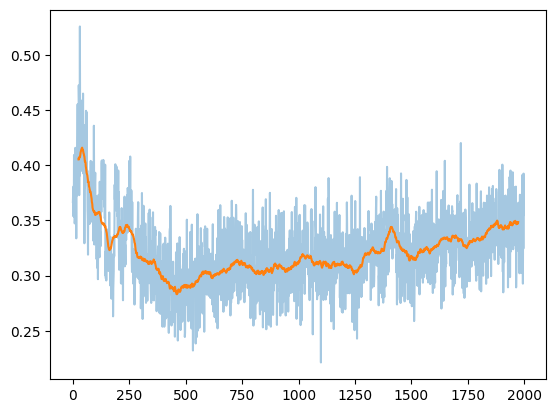

In [11]:
name_val = 'v27'

t0 = time.time()

error_hist_val = []

for batch in range(1, 2000):#n_training_data + 1):

    if batch % 250 == 0:
        print(batch)

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name_val, index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name_val, index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)
    
    # get error of new data (without backprop)
    model.eval()
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist_val.append(loss.item())

print('time in total: ', time.time() - t0)

av_window = 50
plt.plot(error_hist_val, alpha=0.4)
plt.plot(range(av_window//2, len(error_hist_val) - av_window//2), [np.nanmean(error_hist_val[i:(i+av_window)]) for i in range(len(error_hist_val) - av_window)], label='mean')
plt.show()


250
500
750
1000
1250
1500
1750
time in total:  138.62658405303955


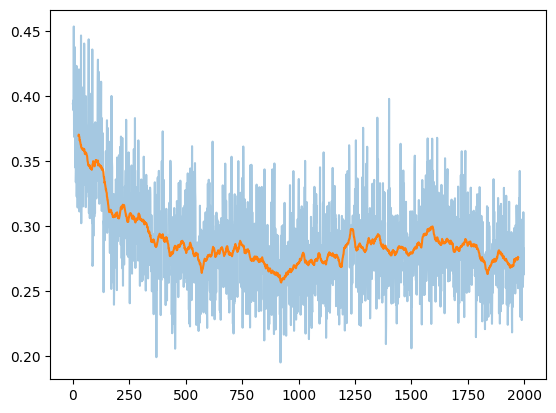

In [12]:
name_val = 'v8_3'

t0 = time.time()

error_hist_val = []

for batch in range(1, 2000):#n_training_data + 1):

    if batch % 250 == 0:
        print(batch)

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name_val, index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name_val, index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)
    
    # get error of new data (without backprop)
    model.eval()
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist_val.append(loss.item())

print('time in total: ', time.time() - t0)

av_window = 50
plt.plot(error_hist_val, alpha=0.4)
plt.plot(range(av_window//2, len(error_hist_val) - av_window//2), [np.nanmean(error_hist_val[i:(i+av_window)]) for i in range(len(error_hist_val) - av_window)], label='mean')
plt.show()


Model_v29
number of parameters:  26011521
10
20
30
40
50
60
70
80
90
100


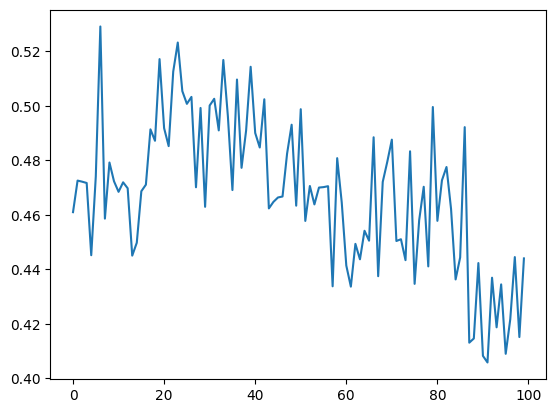

110
120
130
140
150
160
170
180
190
200


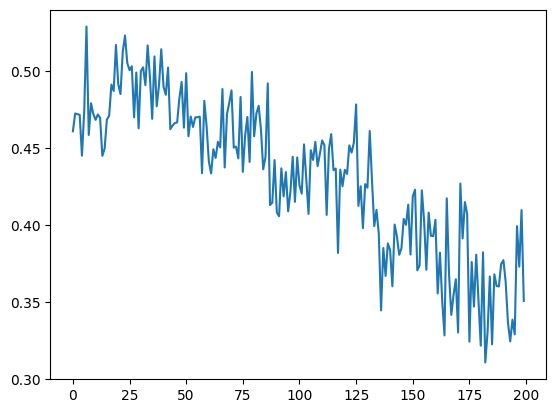

210
220
230
240
250
model:  29 training batch  250
260
270
280
290
300


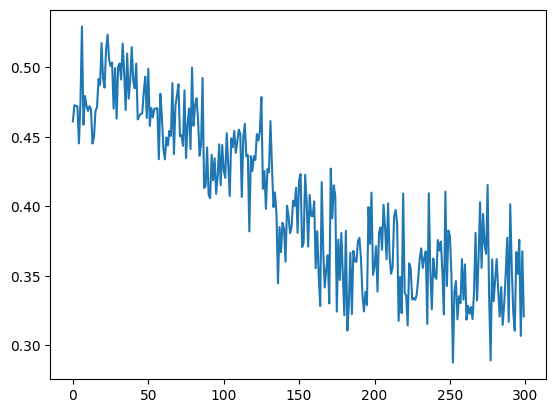

310
320
330
340
350
360
370
380
390
400


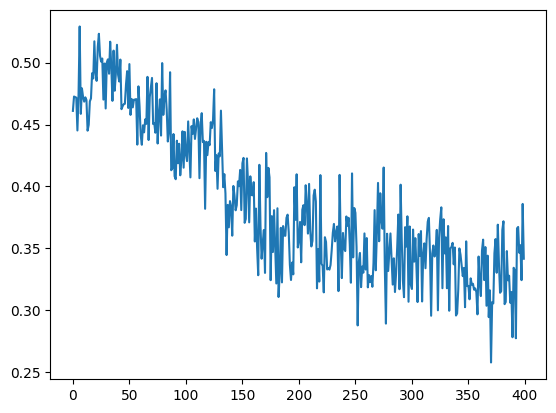

410
420
430
440
450
460
470
480
490
500
model:  29 training batch  500


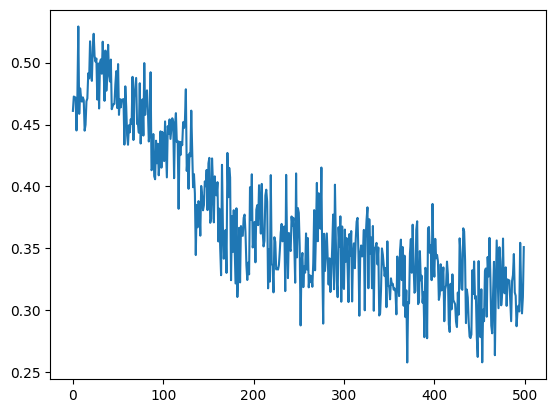

510
520
530
540
550
560
570
580
590
600


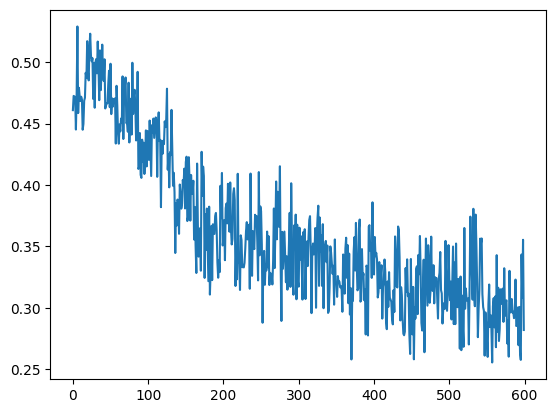

610
620
630
640
650
660
670
680
690
700


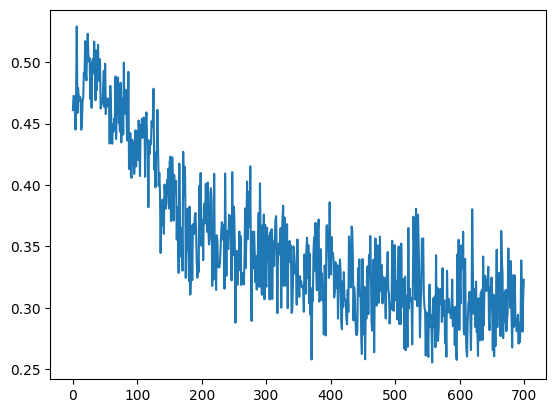

710
720
730
740
750
model:  29 training batch  750
760
770
780
790
800


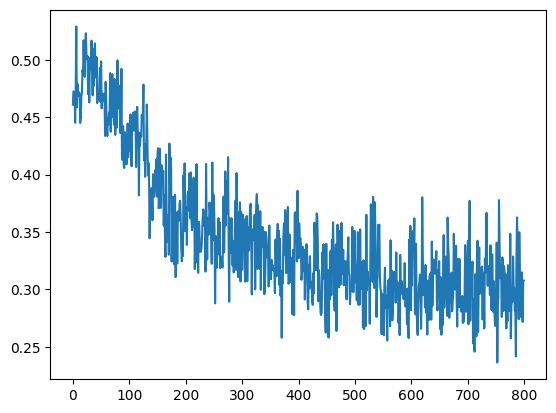

810
820
830
840
850
860
870
880
890
900


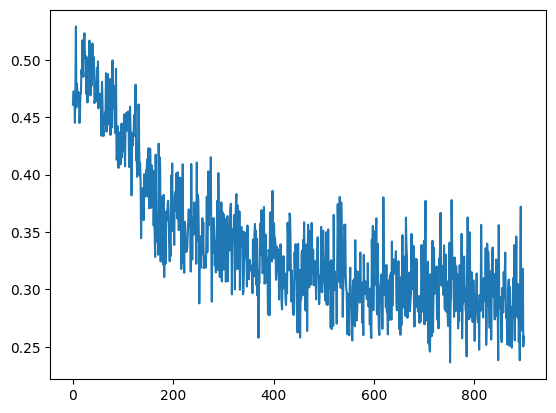

910
920
930
940
950
960
970
980
990
1000
model:  29 training batch  1000


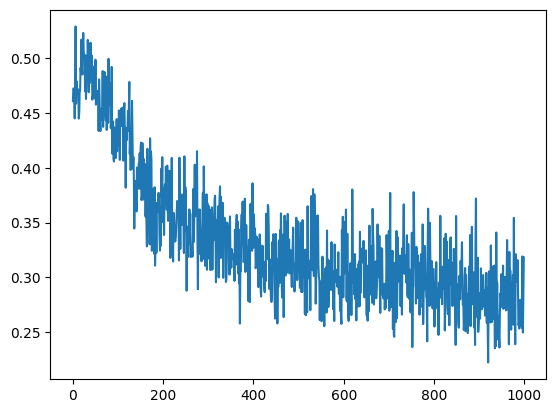

1010
1020
1030
1040
1050
1060
1070
1080
1090
1100


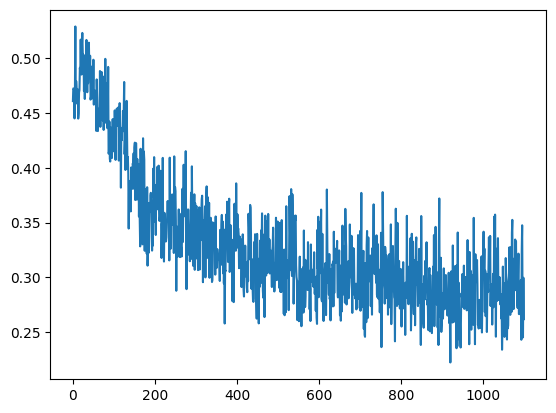

1110
1120
1130
1140
1150
1160
1170
1180
1190
1200


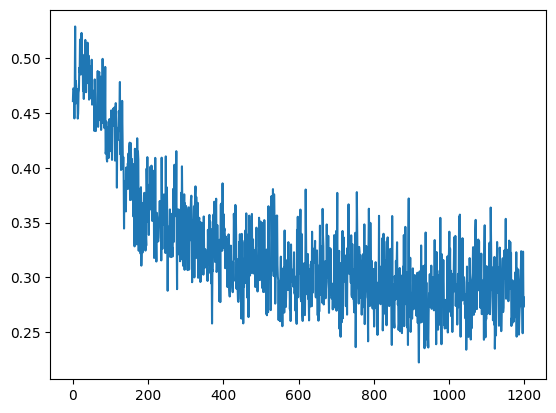

1210
1220
1230
1240
1250
model:  29 training batch  1250
1260
1270
1280
1290
1300


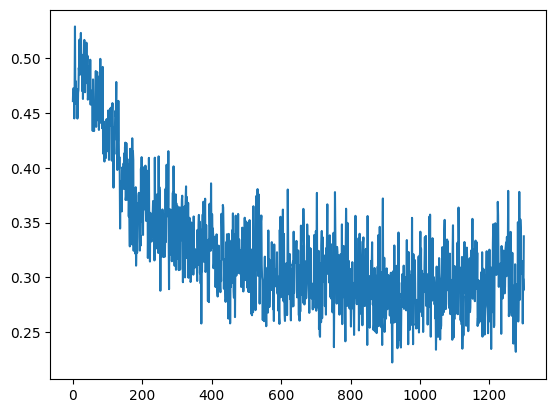

1310
1320
1330
1340
1350
1360
1370
1380
1390
1400


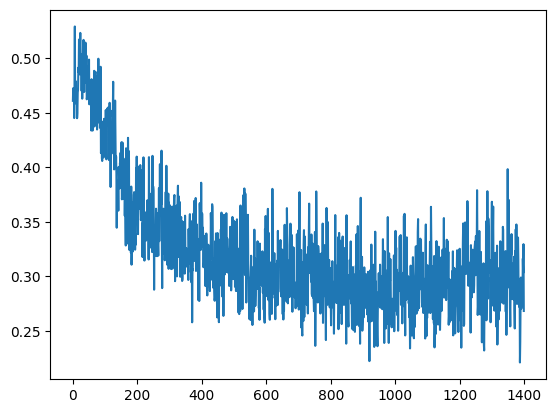

1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
model:  29 training batch  1500


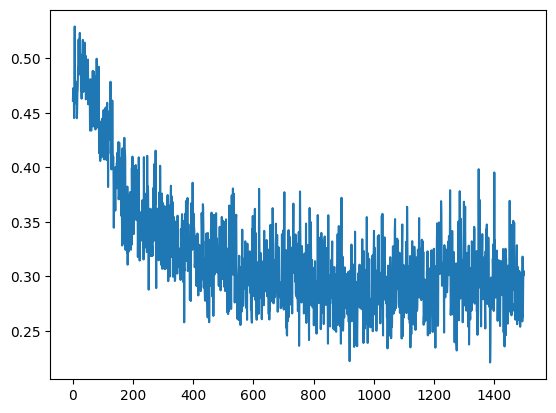

1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


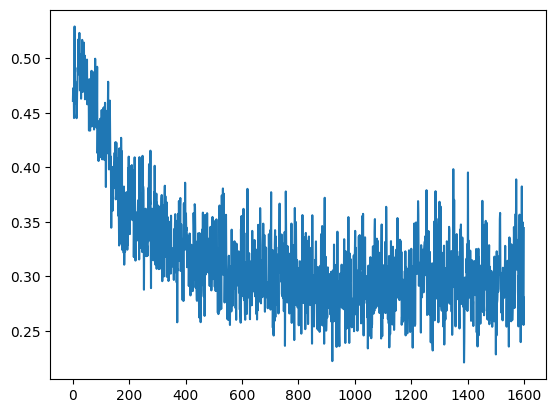

1610
1620
1630
1640
1650
1660
1670
1680
1690
1700


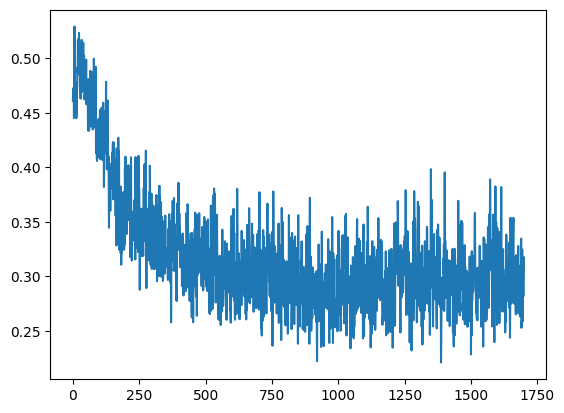

1710
1720
1730
1740
1750
model:  29 training batch  1750
1760
1770
1780
1790
1800


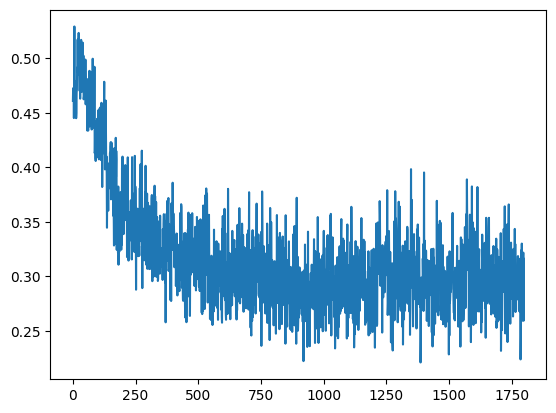

1810
1820
1830
1840
1850
1860
1870
1880
1890
1900


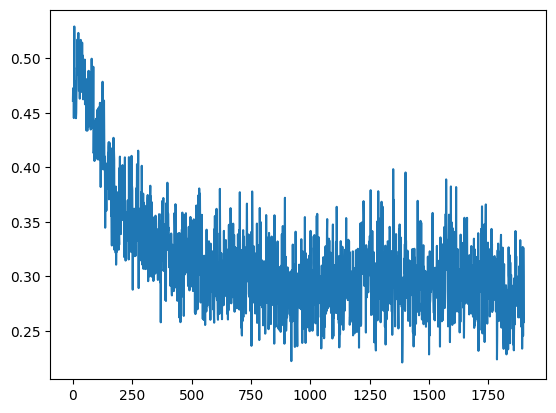

1910
1920
1930
1940
1950
1960
1970
1980
1990
time in total:  56876.5121819973


In [4]:
models_used = [29]
name = 'v8_3'

error_hist_tot_models_v29 = []
criterion = nn.MSELoss()

lr0 = 1e-4
a = 250
n_batches = 1
n_replay = 10            # replay helps, but takes too long here
weight_decay = 1e-7

for func in dir(Resources.Model):

    # 13 is too large, takes too long (4x as long as second most time taken)
    if 'Model_v' in func and int(func[7:]) in models_used:

        model_ind = int(func[7:])
        model = getattr(Resources.Model, func)()
        print(func)

        pars = [i for i in model.parameters()]
        print('number of parameters: ', sum(i.numel() for i in model.parameters()))
    
    else:
        continue

    t0 = time.time()

    error_hist_curr_models = []

    for batch in range(1, 2000):#n_training_data + 1):

        if batch % 10 == 0:
            print(batch)

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        
        # get error of new data (without backprop)
        model.eval()
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 250 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            # error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if batch % 100 == 0:
            plt.plot(error_hist_curr_models)
            plt.show()

    print('time in total: ', time.time() - t0)

    error_hist_tot_models_v29.append(error_hist_curr_models)

    torch.save(error_hist_curr_models, './error temp {}'.format(model_ind))